# Detecting Breast Cancer, Invasive Ductal Carcinoma (IDC), from Histopathology image patches using Convolutional Neural Network

### Import PyTorch and related modules

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

### Pre-processing and Dataloader

In [2]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
batch_size = 32
num_workers = 0

train_transform = transforms.Compose([transforms.Resize(50),
                                      transforms.CenterCrop(50),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means, stds)])

transform = transforms.Compose([transforms.Resize(50),
                                transforms.CenterCrop(50),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

train_dataset = datasets.ImageFolder(root='IDC_full_dataset', transform=train_transform)
valid_dataset = datasets.ImageFolder(root='IDC_full_dataset', transform=transform)

train_size = 0.8
num_train = len(train_dataset)
indices = list(range(num_train))
valid_split = int(np.floor(train_size * num_train))
test_split = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers),
    'valid': torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=num_workers),
    'test' : torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size=batch_size, 
                                          sampler=test_sampler, 
                                          num_workers=num_workers)
}

### Use GPU if available

In [3]:
use_cuda = torch.cuda.is_available()

use_cuda

False

### CNN Architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 2, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 2, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 2, padding=1)

    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64*7*7, 1024)
    self.fc2 = nn.Linear(1024, 2)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # flatten image input
    x = x.view(-1, 64*7*7)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [5]:
model = Net()

print(model)

if use_cuda:
  model = model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Train method

In [6]:
import time

def train(epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  valid_loss_min = np.Inf
  start_time = time.time()

  for epoch in range(1, epochs+1):
    epoch_start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      train_loss += ((1 / (batch_idx +1)) * (loss.data - train_loss))


    ### VALIDATION
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()

      val_output = model(data)
      val_loss = criterion(val_output, target)
      valid_loss = ((1 / (batch_idx + 1)) * (val_loss.data - valid_loss))


    # print training and validation statistics    
    print('Epoch: {}/{} \t\tTime taken: {:.6f} seconds'.format(epoch, epochs, time.time()-epoch_start_time))
    print('------------------------------------------------------------------')
    print('Training Loss: {:.6f}    Validation Loss: {:.6f}\n'.format(train_loss, valid_loss))
    

    # save model if validation loss is decreasing
    if(valid_loss < valid_loss_min):
      print('-------------------------  SAVING MODEL  -------------------------')
      print('Old Validation Loss: {:.6f}   >>>>>   New Validation Loss: {:.6f}\n'.format(
          valid_loss_min,
          valid_loss
      ))
      valid_loss_min = valid_loss
      torch.save(model.state_dict(), save_path)

  print('\nTotal Training Time: {:.6f} seconds'.format(time.time()-start_time))
  return model

### Optimizer and Loss Function

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

### Traning

In [10]:
# model_path = 'cnn_model_10_adam_fullmodel.pt'
model_path_test = 'cnn_model_full_50_adam.pt'

In [11]:
model = train(50, loaders, model, optimizer, criterion, use_cuda, model_path_test)

Epoch: 1/50 		Time taken: 1096.861897 seconds
------------------------------------------------------------------
Training Loss: 0.405541    Validation Loss: 0.000527

-------------------------  SAVING MODEL  -------------------------
Old Validation Loss: inf   >>>>>   New Validation Loss: 0.000527

Epoch: 2/50 		Time taken: 982.298002 seconds
------------------------------------------------------------------
Training Loss: 0.405743    Validation Loss: 0.000462

-------------------------  SAVING MODEL  -------------------------
Old Validation Loss: 0.000527   >>>>>   New Validation Loss: 0.000462

Epoch: 3/50 		Time taken: 977.500406 seconds
------------------------------------------------------------------
Training Loss: 0.415768    Validation Loss: 0.000519

Epoch: 4/50 		Time taken: 952.088165 seconds
------------------------------------------------------------------
Training Loss: 0.409178    Validation Loss: 0.000452

-------------------------  SAVING MODEL  -----------------------

Epoch: 45/50 		Time taken: 2123.269129 seconds
------------------------------------------------------------------
Training Loss: 0.394749    Validation Loss: 0.000530

Epoch: 46/50 		Time taken: 2185.692260 seconds
------------------------------------------------------------------
Training Loss: 0.390692    Validation Loss: 0.000450

Epoch: 47/50 		Time taken: 2150.889873 seconds
------------------------------------------------------------------
Training Loss: 0.389358    Validation Loss: 0.000362

Epoch: 48/50 		Time taken: 1993.670755 seconds
------------------------------------------------------------------
Training Loss: 0.403305    Validation Loss: 0.000142

-------------------------  SAVING MODEL  -------------------------
Old Validation Loss: 0.000174   >>>>>   New Validation Loss: 0.000142

Epoch: 49/50 		Time taken: 1984.073406 seconds
------------------------------------------------------------------
Training Loss: 0.395880    Validation Loss: 0.000599

Epoch: 50/50 		Time ta

### Confusion matrix helper method for model evaluation

In [16]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_confusion_matrix(data, normalize, outputfile):
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9,6))
    
    labels = ['Cancerous', 'Not Cancerous']
    
    if normalize:
        seaborn.set(font_scale=1.4)
        plt.title('Confusion Matrix, Normalized')
        conf_data = np.array(data)/27753
        seaborn.set(font_scale=2)
        ax = seaborn.heatmap(conf_data, annot=True, cmap='Blues', cbar_kws={'label': 'Scale'})
        
    else:
        seaborn.set(font_scale=1.4)
        plt.title('Confusion Matrix')
        conf_data = data
        seaborn.set(font_scale=2)
        ax = seaborn.heatmap(conf_data, annot=True, cmap='Blues', cbar_kws={'label': 'Scale'}, fmt='g')
    
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    ax.set(ylabel='Predicted Label', xlabel='True Label')
    
    plt.savefig(outputfile, bbox_inches='tight', dpi=300)
    
    plt.show()
    plt.close() 

### Test Method

In [13]:
def test(loaders, model, criterion, use_cuda):
    test_loss = 0.0
    correct = 0.0
    total = 0.0
    all_preds = []
    all_targets = []
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        test_loss += ((1 / (batch_idx +1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
        # for metrics calculations
        for prediction in pred.tolist():
            all_preds.append(prediction)
    
        for targ in target.tolist():
            all_targets.append(targ)
    
    
    # Confusion matrix calculation
    for ii in range(len(all_targets)):
        if all_targets[ii] == 1:
            if all_preds[ii] == [1]:
                true_positive += 1
            elif all_preds[ii] == [0]:
                false_negative += 1
        elif all_targets[ii] == 0:
            if all_preds[ii] == [1]:
                false_positive += 1
            elif all_preds[ii] == [0]:
                true_negative += 1
                

    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
    print('-----------------------------------\n')
    print('Evaluation Metrics:\n')
    print('Total: {}\n'.format(len(all_preds)))
    print('Confusion Matrix')
    print('TP: {}    FP: {}\nFN: {}    TN: {}'.format(true_positive, false_positive, false_negative, true_negative))
    
    accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    print('\nAccuracy: %.2f%%' % (accuracy * 100.))
    print('Precision: %.2f%%' % (precision * 100.))
    print('Recall: %.2f%%' % (recall * 100.))
    print('F1 Score: %.2f%%' % (f1_score * 100.))
    
    confusion_data = [[true_positive, false_positive],
                     [false_negative, true_negative]]
    
    plot_confusion_matrix(confusion_data, False, 'confusion_matrix.png')
    plot_confusion_matrix(confusion_data, True, 'confusion_matrix_normalize.png')

### Load trained model

In [14]:
model_path = 'cnn_model_full_50_adam.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Testing

Test Loss: 0.375631
Test Accuracy: 84% (23317/27753)
-----------------------------------

Evaluation Metrics:

Total: 27753

Confusion Matrix
TP: 5557    FP: 2072
FN: 2364    TN: 17760

Accuracy: 84.02%
Precision: 72.84%
Recall: 70.16%
F1 Score: 71.47%


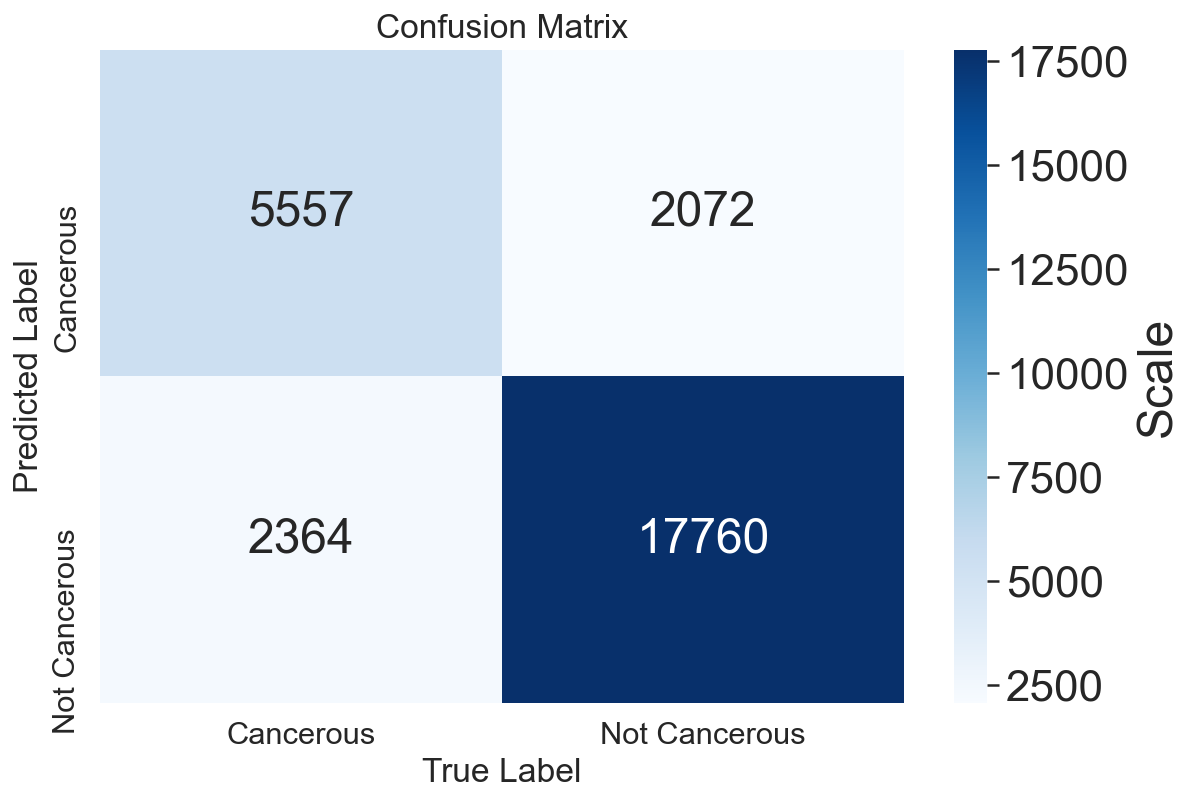

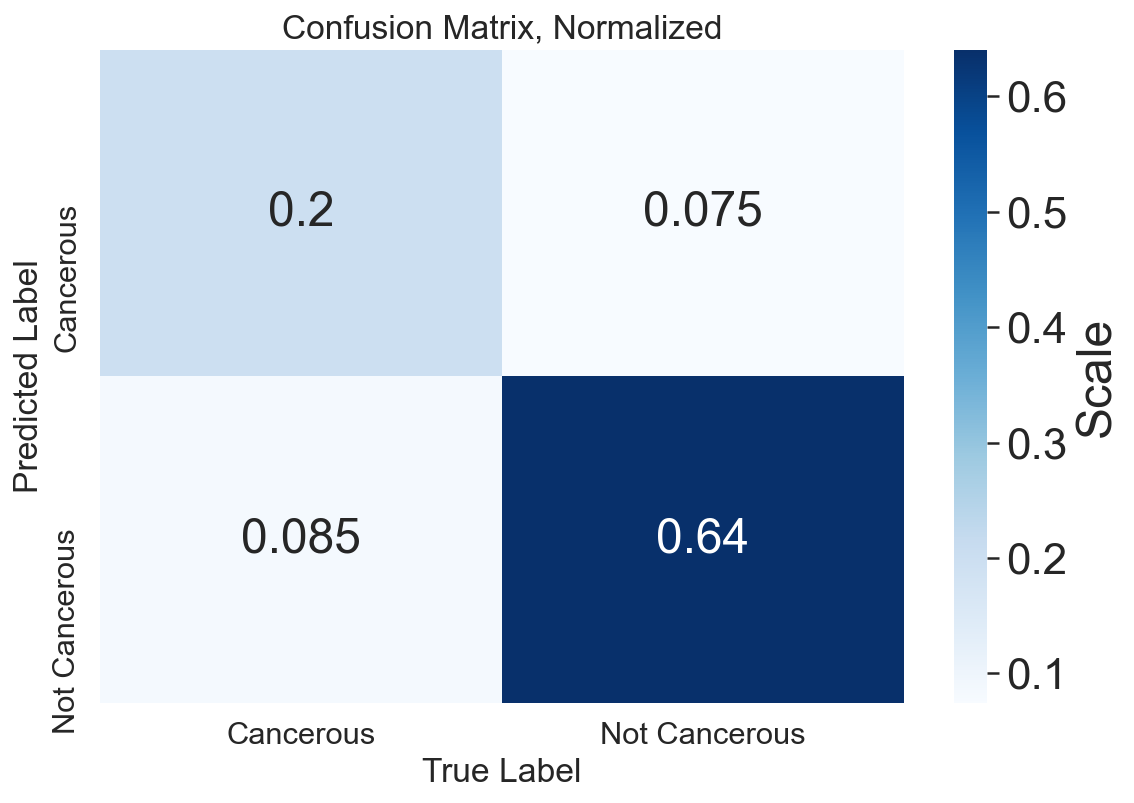

In [17]:
test(loaders, model, criterion, use_cuda)